<a href="https://colab.research.google.com/github/Elmir22/Data-science-ML-models-/blob/main/Times_series_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf


tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [2]:
import pandas as pd
from pathlib import Path

path = Path("/content/datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # no need for total, it's just bus + rail
df = df.drop_duplicates() # remove duplicated months ( 2022-10 and 2014-07)


In [3]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


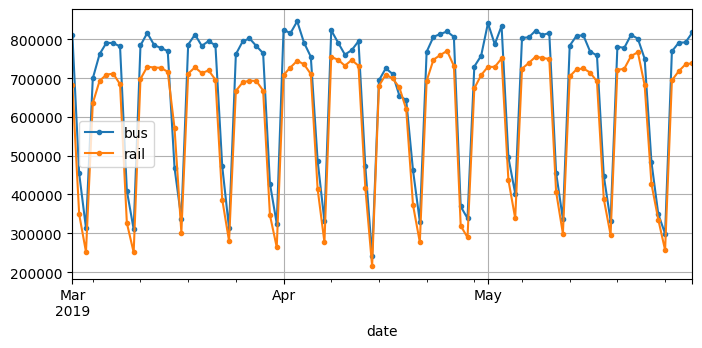

In [4]:
import matplotlib.pyplot as plt

df["2019-03": "2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

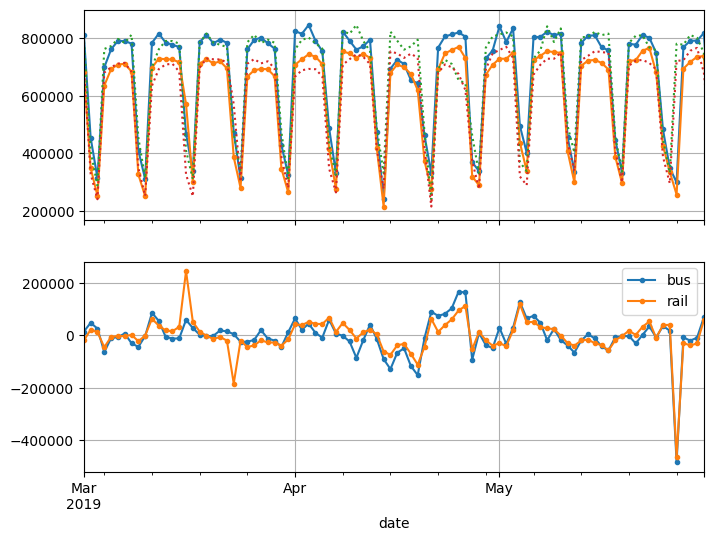

In [5]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03": "2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
df.plot(ax=axs[0], legend=False, marker=".", grid=True) # orginal time series
df.shift(7).plot(ax=axs[0], legend=False, grid=True, linestyle=":")#legend
diff_7.plot(ax=axs[1], marker=".", grid=True)# 7-day difference time series
axs[0].set_ylim([170_000, 900_000]) #extra code - beautifies the plot
plt.show()


In [6]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [7]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [8]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

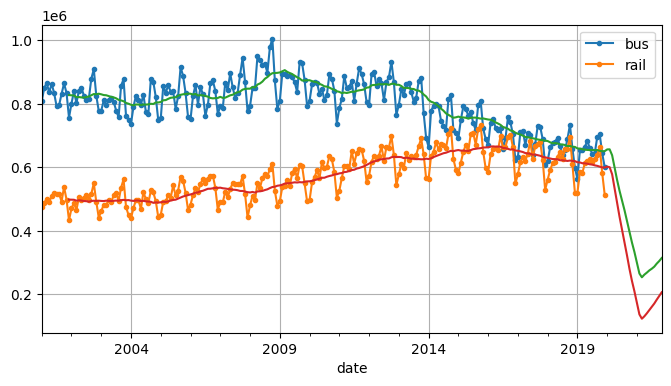

In [11]:
period = slice("2001", "2019")
df_monthly = df.resample("M").mean(numeric_only=True)
rolling_average_12_months = df_monthly.rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

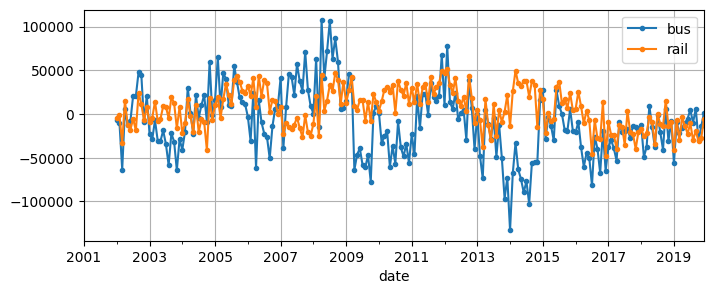

In [12]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()

In [ ]:
import sys
if "google.colab" in sys.modules:
    !pip install -q -U statsmodels

In [16]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1, 0, 0),seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              rail   No. Observations:                  150
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1844.697
Date:                           Fri, 12 Jul 2024   AIC                           3695.394
Time:                                   11:20:07   BIC                           3704.282
Sample:                               01-01-2019   HQIC                          3699.005
                                    - 05-30-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6485      0.052     12.532      0.000       0.547       0.750
ma.S.L7       -0.6627      0.076     -8.737      0.000      -0.811      -0.514
sigma2      1.171e+10   1.22e-12   9.58e+21      0.000    1.17e+10    1.17e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               978.72
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -1.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [17]:
y_pred[0]

427758.62641035335

In [18]:
df["rail"].loc["2019-06-01"]

379044

In [19]:
df["rail"].loc["2019-05-25"]

426932

In [24]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start=start_date, end=end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
  model = ARIMA(rail_series[origin:today],
                order=(1, 0, 0),
                seasonal_order=(0,1,1,7))
  model = model.fit()
  y_pred = model.forecast()
  y_preds.append(y_pred.iloc[0])

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [25]:
mae

32040.720089453378

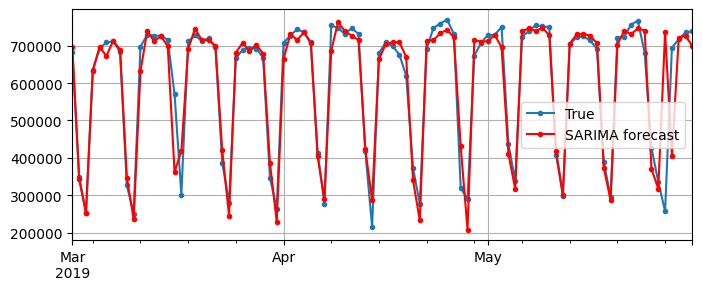

In [26]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA forecast")
plt.legend()
plt.show()

In [28]:
import tensorflow as tf

my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets = my_series[3:],
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [29]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
  for element in window_dataset:
    print(f"{element}", end=" ")
  print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [30]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
  print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [31]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [32]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [33]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-12"] / 1e6
rail_test = df["rail"]["2019-06":] /1e6


In [35]:
from random import seed
seq_length = 56
tf.random.set_seed(42)

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle = True,
    seed = 42)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32)

In [38]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=50, monitor="val_mae", restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 2s 20ms/step - loss: 0.0582 - mae: 0.2440 - val_loss: 0.0134 - val_mae: 0.1250
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0092 - mae: 0.1041 - val_loss: 0.0099 - val_mae: 0.1021
Epoch 3/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0077 - mae: 0.0935 - val_loss: 0.0088 - val_mae: 0.0944
Epoch 4/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0069 - mae: 0.0873 - val_loss: 0.0076 - val_mae: 0.0876
Epoch 5/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0064 - mae: 0.0831 - val_loss: 0.0073 - val_mae: 0.0852
Epoch 6/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0060 - mae: 0.0801 - val_loss: 0.0072 - val_mae: 0.0832
Epoch 7/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0057 - mae: 0.0785 - val_loss: 0.0069 - val_mae: 0.0807
Epoch 8/500
33/33 [==============================] - 1s 15ms/step - loss: 0.